# Ensemble Learning Methods

In the [Decision Trees and Random Forests notebook](Decison_Trees.ipynb), we talked about how Random Forests we one class of ensemble methods. Here we will look more at the details and explore additional ensemble methods.

## Homogeneous ensemble methods

### Bagging

As mentioned, Random Forests employ what is known as **bagging**. We used the analogy of a grab bag to justify the name, but bagging is also short for **bootstrap aggregating**. As described with random forest methods, we create many bootstrap datasets and then create indepentent decision treees for each dataset and aggregate their results (somehow--we'll cover that in a bit).   

Here's a graphical summary of random forests and bagging:

![Random Forests with Baggining](images/Random_Forest.png)


### Boosting

With bagging each model is built independantly and then aggregated. Boosting changes this to allow individual models to be build in series, with each model learning from the previous model.

The learning process differs among boosting methods, but in most cases, the data selected for each model fitting step are not random. Instead, misclasified points are up-weighted in the selection for the next round, increasing their probability of being selected. 

In the diagram below, I have tried to convey how the points selected start somewhat random, but become more focused on the points near class boundaries (likely misclassified) from iteration to iteration.

Also note that while I am illustrating ensemble methods with decision trees, these methods are regularly applied to other ML mothods.

![Example of boosting](images/Boosting.png)

#### Adaptive Boosting (AdaBoost)

AdaBoost was one of the first boosting methods intorduced and the main idea is to use a series of weak classifiers (the initial implementation was decision trees with a depth of 1). The general method described above, where weights are adjusted to increase focus on misclassified samples is the AdaBoost method. The default weak classifier is a decision tree with depth of 1, also known as a **decision stump**.     

![AdaBoost diagram showing decision stumps](images/AdaBoost.png)

#### Gradient Boosting (GBM)

While AdaBoost focused weights on incorrectly classified data points, Gradient Boosting updates each step by employing a loss function. Remember MSE as an example loss function in regression. One advantage of Gradient Boosting is the ability to specify the desired loss function.

1. A loss function -- uses diffentiation to calculate loss
1. A weak learner -- typically again decision stumps, but other weak models possible
1. An adaptive model -- a sequence of decision trees updated with each iteration using the residuals from the previous tree.

[See this great visual and explanation](https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) by Alex Rogozhnikov.


In a somewhat non-mathematical way, the explanation from the above page point shows how the predictions from individual trees are summed. So for example, when the ensemble has 3 trees in the prediction, we have:

$$ D(x) = d_{tree1}(x) + d_{tree2}(x) + d_{tree3}(x) $$

> The next tree ($tree4$) in the ensemble should complement well the existing trees and minimize the training error of the ensemble. In the ideal case we'd be happy to have:

$$ D(x) + d_{tree4}(x) = f(x) $$

> To get a bit closer to the destination, we train a tree to reconstruct the difference between the target function and the current predictions of an ensemble, which is called the residual:

$$ R(x) = f(x) - D(x) $$

> Did you notice? If decision tree completely reconstructs $R(x)$, the whole ensemble gives predictions without errors (after adding the newly-trained tree to the ensemble)! That said, in practice this never happens, so we instead continue the iterative process of ensemble building.


##### Shrinkage

As shown above the residuals are used at each step for the next tree in the process. One tuning parameter that has been shown to help is the **learning rate**. By lowering the learning rate (called shrinkage), often to around 0.1, models tend to perform better than models without shrinkage (learning rate = 1).

#### Stochastic Gradient Boosting

Rather than using all of the training data at each step to calculat ethe residues, it has been shown that using a bootstrap sample improves performance. It is common to sample half (`subsample=0.5`) of the data. Since this adds stochasticisty to gradient descent, it is reffered to as Stochastic Gradient Boosting.

#### Extreme Gradient Boosting (gdboost)

gdboost is an efficient implimentation of many boosting methods. It is written in C++ and has has efficiency as a focus from the start. Lukily for us, there are Python interfaces, including sklearn, so we can make use of gdboost in our familiar environment.


## Heterogeneous ensemble methods

### Stacking

In stacking, diffetent methods are used, and then the models fed to a stacking learner that learns how best to combine the models.

![Stacking image](images/Stacking.png)

## Let's play with these....

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
import graphviz

import helpers_05_08 # A set of visualization helpers from PDSH text

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn import metrics

from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot # Leaving this to avoid lots of code re-writing.
from sklearn.ensemble import StackingClassifier

import warnings
warnings.filterwarnings('ignore')


### AdaBoost, Gradient Boosting and SGD on the Wine data

In [4]:
# Load the data
df= pd.read_csv('/blue/zoo6927/share/Jupyter_Content/data/winequality-red.csv')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [5]:
X = df.drop(columns='quality')
y = df['quality'].apply(lambda y_data: 1 if y_data>=6 else 0) # Transform the data to Good (6+) and bad (<6) wines.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


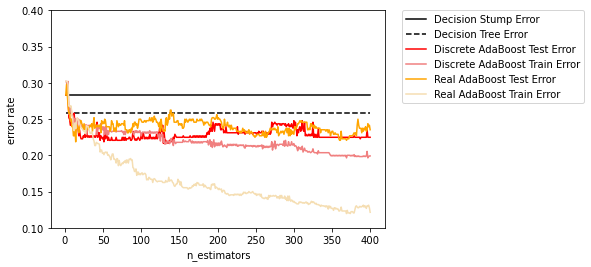

In [10]:
# This example is adapted from 
#  https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html#sphx-glr-auto-examples-ensemble-plot-adaboost-hastie-10-2-py
#  Original author: Peter Prettenhofer <peter.prettenhofer@gmail.com>,
#         Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

n_estimators = 400
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

# Get the decision tree stumps (max_depth=1)
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

# Get the full decision tree
dt = DecisionTreeClassifier(min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

# AdaBoost SAMME reweights based on class prediction
ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

# AdaBoost SAMME.R reweights baed on class probability
ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

# Gradient Descent Boosting
#gdboost = GradientBoostingClassifier(
#    n_estimators=n_estimators
#)
#gdboost.fit(X_train, y_train)

# Stochastic Gradient Descent
#SGD = GradientBoostingClassifier(
#    n_estimators=n_estimators,
#    subsample=0.5
#)
#SGD.fit(X_train,y_train)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

# ada_discrete err on test/train
ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)
    
ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

# ada_real err on test/train
ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

# gdboost err on test/train
#gdboost_err = np.zeros((n_estimators,))
#for i, y_pred in enumerate(gdboost.staged_predict(X_test)):
#    gdboost_err[i] = zero_one_loss(y_pred, y_test)
#    
#gdboost_err_train = np.zeros((n_estimators,))
#for i, y_pred in enumerate(gdboost.staged_predict(X_train)):
#    gdboost_err_train[i] = zero_one_loss(y_pred, y_train)

# SDG err on test/train
#SGD_err = np.zeros((n_estimators,))
#for i, y_pred in enumerate(SGD.staged_predict(X_test)):
#    SGD_err[i] = zero_one_loss(y_pred, y_test)
#    
#SGD_err_train = np.zeros((n_estimators,))
#for i, y_pred in enumerate(SGD.staged_predict(X_train)):
#    SGD_err_train[i] = zero_one_loss(y_pred, y_train)

# Discrete ada    
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='lightcoral')

# Real ada
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='wheat')

# gdboost
#ax.plot(np.arange(n_estimators) + 1, gdboost_err,
#        label='gdboost Test Error',
#        color='purple')
#ax.plot(np.arange(n_estimators) + 1, gdboost_err_train,
#        label='gdboost Train Error',
#        color='violet')

# SDG
#ax.plot(np.arange(n_estimators) + 1, SGD_err,
#        label='SGD Test Error',
#        color='green')
#ax.plot(np.arange(n_estimators) + 1, SGD_err_train,
#        label='SDG Train Error',
#        color='lightgreen')

ax.set_ylim((0.1, 0.4))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()


## Stacking

This code is adapted from Jason Brownlee's article [Stacking Ensemble Machine Learning With Python](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/)


>lr 0.738 (0.031)
>knn 0.657 (0.036)
>cart 0.768 (0.034)
>svm 0.635 (0.031)
>bayes 0.728 (0.036)


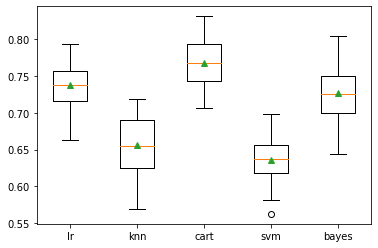

In [16]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The boxplots above show the accuracy scores for each method. In this case, it looks like decision trees (`cart`) perform the best, but all seem reasonable approaches.

We can combine these models using logistic regression to learn how best to combine the models.



>lr 0.738 (0.031)
>knn 0.657 (0.036)
>cart 0.767 (0.035)
>svm 0.635 (0.031)
>bayes 0.728 (0.036)
>stacking 0.741 (0.033)


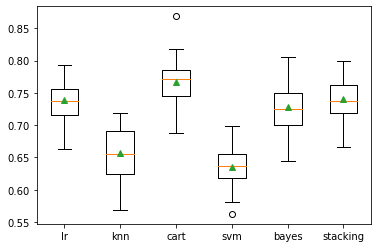

In [20]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()